# News Language model

### this is a joint affair of Armin Behjati and Bahram Mohammadpour

We are already familiar with the idea of using a pre trained network and adding some layers to the top and make it do something different in computer vision .
It's the simple idea of a backbone plus a custom head that ables us almost do anything we can think about !
Here we try to apply the same idea to NLP .


In this notebook we try to train a Language model on persian news files and then use this model to train a classifier predicting the news categories .

Most of the code and models here were available thanks to fastai and Jeremy Howard .

We are going to use fastai.text here instead of torchtext which was very slow and confusing . 

In [1]:
import warnings
warnings.filterwarnings("ignore")
from fastai.text import *
import html

/home/bahram/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Setting the path of our data and a path to store the language model .

In [2]:
BOS = 'xbos'  
FLD = 'xfld'  

PATH=Path('data/')

In [3]:
LM_PATH=Path('data/news_lm/')
LM_PATH.mkdir(exist_ok=True)

The news files from the crawler were stored in a Pandas dataframe named 'news_out'.

In [4]:
df = pd.read_pickle('news_out')

as you can see there are some blanks here that we need get rid of .

In [5]:
df.head()

,text,label
0,,5
1,معاون بازاريابي فروش ايران خودرو با بيان اين ...,5
2,,5
3,,5
4,به گزارش روابط عمومی واموربین الملل سازمان منط...,5


In [6]:
df['text'].replace('', np.nan, inplace=True)

In [7]:
df.head()

,text,label
0,NaN,5
1,معاون بازاريابي فروش ايران خودرو با بيان اين ...,5
2,NaN,5
3,NaN,5
4,به گزارش روابط عمومی واموربین الملل سازمان منط...,5


In [8]:
df.dropna(subset=['text'], inplace=True)

In [9]:
df.shape

(10171, 2)

In [10]:
df.head()

,text,label
1,معاون بازاريابي فروش ايران خودرو با بيان اين ...,5
4,به گزارش روابط عمومی واموربین الملل سازمان منط...,5
5,بانک رفاه در راستای سیاست ها و تصمیمات ارزی مت...,5
6,مديرعامل سازمان منطقه آزاد كيش توجه به ارتقاء ...,5
8,مدیرعامل بیمه ایران می‌گوید درباره نحوه پرداخت...,5


In this part we try standardize the dataframe . each row has two columns for the news text and the news label.

In [11]:
cols = df.columns.tolist()
cols

['text', 'label']

In [12]:
cols = cols[-1:] + cols[:-1]
cols

['label', 'text']

In [13]:
df = df[cols]
df.head()

,label,text
1,5,معاون بازاريابي فروش ايران خودرو با بيان اين ...
4,5,به گزارش روابط عمومی واموربین الملل سازمان منط...
5,5,بانک رفاه در راستای سیاست ها و تصمیمات ارزی مت...
6,5,مديرعامل سازمان منطقه آزاد كيش توجه به ارتقاء ...
8,5,مدیرعامل بیمه ایران می‌گوید درباره نحوه پرداخت...


In [14]:
df.rename(columns = {'label':'labels'}, inplace = True)
df.head()

,labels,text
1,5,معاون بازاريابي فروش ايران خودرو با بيان اين ...
4,5,به گزارش روابط عمومی واموربین الملل سازمان منط...
5,5,بانک رفاه در راستای سیاست ها و تصمیمات ارزی مت...
6,5,مديرعامل سازمان منطقه آزاد كيش توجه به ارتقاء ...
8,5,مدیرعامل بیمه ایران می‌گوید درباره نحوه پرداخت...


split_vals is a function we use to make validation set

In [15]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

we use 9000 news files for the train and the rest for validation 

In [16]:
n_trn = 9000
df_train, df_valid = split_vals(df, n_trn)

In [17]:
df_valid.shape

(1171, 2)

We don't need news labels for language model so we set'em all to zero .

In [18]:
df_train['labels'] = 0

In [19]:
df_valid['labels'] = 0

In [20]:
df_train.head()

,labels,text
1,0,معاون بازاريابي فروش ايران خودرو با بيان اين ...
4,0,به گزارش روابط عمومی واموربین الملل سازمان منط...
5,0,بانک رفاه در راستای سیاست ها و تصمیمات ارزی مت...
6,0,مديرعامل سازمان منطقه آزاد كيش توجه به ارتقاء ...
8,0,مدیرعامل بیمه ایران می‌گوید درباره نحوه پرداخت...


we should save the training and validation data for further use

In [21]:
df_train.to_pickle('LM_train_df.pkl')
df_valid.to_pickle('LM_valid_df.pkl')

In [22]:
df_train.to_csv('train.csv', header=False, index=False)
df_valid.to_csv('valid.csv', header=False, index=False)

In [23]:
df_train.text[1]

'\xa0معاون بازاريابي فروش ايران خودرو با بيان اين كه اجراي روش هاي متنوع و جامع براي فروش محصولات يكي از مسيرهاي افزايش رضايتمندي مشتريان و فراهم كردن امكان خريد كالاي ايراني است تاكيد كرد: ايران خودرو در سال حمايت از كالاي ايراني برنامه هاي متنوعي را براي خريد محصولات به اجرا خواهد گذاشت. \xa0\xa0 \xa0\xa0به گزارش ايكوپرس، مصطفي خان كرمي با تشريح برنامه هاي فروش ايران خودرو در سال 97، اعمال تخفيف خريد كالاي ايراني را از جمله مشوق هاي خريد محصولات ايران خودرو دانست و اظهار كرد:\u200c با مطالعه و بررسي بازار و نيازسنجي از مشتريان برنامه هاي فروش را منطبق با خواست و سليقه آنان به اجرا مي گذاريم.وي افزود:\u200c طرح هاي فروش را متناسب با بودجه مشتريان در نظر مي گيريم و در اين راستا برنامه هاي فروش اقساطي و اعتباري را طرح ريزي مي كنيم تا همه گروه هاي درآمدي موفق به خريد محصولات ايراني ايران خودرو شوند.خان كرمي طرح هاي پيش فروش را از جمله طرح هاي فروش محصولات ايران خودرو نام برد و گفت: در پيش فروش هايی كه به صورت سرمايه گذاري پيشنهاد مي شود امكان مشاركت مشتريان در فرآيند توليد محصول ايجاد مي

The next thing we need to do is to tokenize the text . unfortunately we couldn't find any good persian tokenizer available so we used the spacy english tokenizer which worked fine for the task !
we pass 'cunksize' when we read the csv file .that means that pandas does not return a data frame, but it returns an iterator that we can iterate through chunks of a data frame.
 That is why we don’t say tok_trn = get_text(df_trn) but instead we call get_all which loops through the data frame but actually what it’s really doing is it’s looping through chunks of the data frame so each of those chunks is basically a data frame representing a subset of the data .

Before we include the text, we have “beginning of stream” (BOS) token which we defined in the beginning.
So every text is going to start with ‘xbos’ because it’s often useful for the model to know when a new text is starting.

we tokenize it by doing a “process all multiprocessing” (proc_all_mp).

There is also a function called partition_by_cores which takes a list and splits it into sublists. The number of sublists is the number of cores that you have in your computer.

We make a list list of all the words that appear in some order.then we replace every word with its index into that list.the list of all the tokens, we call that the vocabulary.

In [24]:
chunksize=1000


In [25]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace(':\u200c', " ").replace('\xa0',' ').replace('\r\n',' ').replace('|',' ').replace('«', '.')
    return re1.sub(' ', html.unescape(x))

In [26]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = list(texts.apply(fixup).values)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

In [27]:
def get_all(df, n_lbls):
    tok, labels = [], []
    
    for i, r in enumerate(df): 
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [28]:
df_trn = pd.read_csv('train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv('valid.csv', header=None, chunksize=chunksize)

In [29]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
2
3
4
5
6
7
8
0
1


Here we just save the tokens 





In [30]:
(LM_PATH/'tmp').mkdir(exist_ok=True)

In [31]:
np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)

In [32]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')

Python counter class gives us a list of unique items and their counts. Here are the 25 most common things in the vocabulary. 

In [33]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

[('و', 219034),
 ('در', 166423),
 ('به', 140454),
 ('از', 104388),
 ('که', 95511),
 ('این', 84752),
 ('را', 72305),
 ('با', 69094),
 (':', 42844),
 ('است', 37288),
 ('برای', 29959),
 ('است.', 26304),
 ('می', 24125),
 ('آن', 22736),
 ('هم', 22181),
 ('یک', 19358),
 ('شده', 19201),
 ('ما', 17422),
 ('کرد', 17408),
 ('های', 17134),
 ('سال', 16955),
 ('بر', 16330),
 ('خود', 16176),
 ('گفت', 15925),
 ('کشور', 15450)]

We use most_common, pass in the max vocab size and that’ll sort it by the frequency and if it appears less often than a minimum frequency, then leave it. That gives us itos — that’s the same name that torchtext used and it means integer-to-string. This is just the list of unique tokens in the vocab. We’ll insert two more tokens — a vocab item for unknown (_unk_) and a vocab item for padding (_pad_).

In [34]:
max_vocab = 50000
min_freq = 2

In [35]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

stoi is a dictionary going in the opposite direction as the itos 

In [36]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

45303

Now we call stoi for every word in sentences 

In [37]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [38]:
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

In [39]:
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

Now our vocab size is 45303 and our training language model has 9000 documents in it.

In [40]:
vs=len(itos)
vs,len(trn_lm)

(45303, 9000)

# Language model

As before we set our embeding size , number of hidden layers and number of layers

In [41]:
em_sz,nh,nl = 400,1150,4


In [42]:
wd=1e-7
bptt=70
bs=32
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

We take all our documents and just concatenate them back to back.we are going to try to predict the next word after these words. once we have a model data object, we can grab the model from it, so that’s going to give us a learner.


In [43]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [44]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7


We grab a learner from ModelData object .

In [45]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.unfreeze()


In [46]:
lr=1e-3
lrs = lr

we use the learning rate finder to find the best learning rate .

In [58]:
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

epoch      trn_loss   val_loss   accuracy                     
    0      7.648032   7.6762     0.041493  



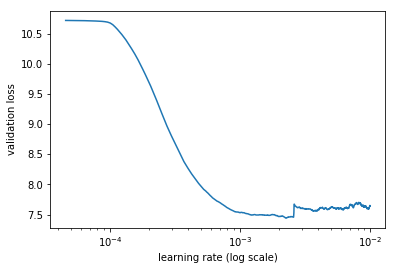

In [59]:
learner.sched.plot()

In [60]:
lr=1e-3
lrs = lr

In [61]:
learner.load('news_LM')

Now we fit the the model for few epochs .

In [53]:
learner.fit(lrs, 5, wds=wd, use_clr=(20,10), cycle_len=15)


epoch      trn_loss   val_loss   accuracy                     
    0      4.148626   5.03116    0.226647  
    1      4.250771   5.047802   0.224713                     
    2      4.304603   5.040141   0.225326                     
    3      4.255172   5.036219   0.225684                     
    4      4.323801   5.016485   0.226707                     
    5      4.151685   5.030256   0.227471                     
    6      4.179784   5.024665   0.226944                     
    7      4.124536   5.018256   0.228459                     
    8      4.089547   5.018955   0.229405                     
    9      4.095399   5.018171   0.229185                     
    10     4.031234   5.021676   0.229044                     
    11     4.111572   5.00962    0.230145                     
    12     3.943506   5.016498   0.230516                     
    13     3.922315   5.016849   0.230894                     
    14     3.990867   5.018164   0.230943                     
    15     

Saving the model .

In [ ]:
learner.save('news_LM')

In [ ]:
learner.save_encoder('LM_enc')

Here is the model architecture .

In [ ]:
m = learner.model
m.eval()

# Generate text

In [50]:
sen = "سیب زمینی"

In [51]:
idxs = np.array([[stoi[p] for p in sen.strip().split(" ")]])
idxs

array([[4226, 2525]])

In [52]:
p = m(VV(idxs))
type(p), len(p)

(tuple, 3)

In [53]:
p[0].shape, [x.shape for x in p[1]], [x.shape for x in p[2]]

(torch.Size([2, 45303]),
 [torch.Size([1, 2, 1150]),
  torch.Size([1, 2, 1150]),
  torch.Size([1, 2, 1150]),
  torch.Size([1, 2, 400])],
 [torch.Size([1, 2, 1150]),
  torch.Size([1, 2, 1150]),
  torch.Size([1, 2, 1150]),
  torch.Size([1, 2, 400])])

In [54]:
t = np.array([[stoi[p] for p in sen.strip().split(" ")]])
t

array([[4226, 2525]])

In [55]:
# Set batch size to 1
m[0].bs=1
# Turn off dropout
m.eval()
# Reset hidden state
m.reset()
# Get predictions from model
res,*_ = m(VV(t))
# Put the batch size back to what it was
m[0].bs=bs

In [56]:
nexts = torch.topk(res[-1], 10)[1]
[itos[o] for o in to_np(nexts)]

['مجددی',
 'شیپینگ',
 'چپاول',
 'تجربه',
 'فیمابین',
 '42',
 'نگرفتیم',
 'برتر',
 'نگرانی',
 'تعدادي']

In [102]:
n=res[-1].topk(2)[1]
n = n[1] if n.data[0]==0 else n[0]

In [103]:
n.data[0] = stoi['تیم']
# .itos[n.data[0]]
res,*_ = m(n[0].unsqueeze(0))
print(itos[n.data[0]], end=' ')
for i in range(50):
    n=res[-1].topk(2)[1]
    
    n = n[1] if n.data[0]==0 else n[0]
#     n = n[random.randint(0,1)]
    print(itos[n.data[0]], end=' ')
    res,*_ = m(n[0].unsqueeze(0))
print('...')

تیم تحقیق و تفحص از این شرکت ها به صورت شبانه روزی به صورت شبانه روزی به محل اعزام شدند. 
 xbos xfld 1 رئیس سازمان بسیج مستضعفین گفت : در حوزه فرهنگ و هنر همواره در حوزه فرهنگ و هنر به عنوان یک نهاد اجتماعی موفق هستیم و در این ...
